In [1]:
# Download Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("risangbaskoro/wlasl-processed")

print("Path to dataset files:", path)

# new dataset name
org_dir = 'videos_org'
org_path = path + '/' + org_dir
directory = 'wlasl_10'
reduced_path = path + '/' + directory
videos_path = path + '/videos'

!source activate video
!python utils/reorg.py {org_dir} 0
# !mkdir -p {reduced_path}
# !mv {org_path}/man    {reduced_path}
# !mv {org_path}/woman  {reduced_path}
# !mv {org_path}/who    {reduced_path}
# !mv {org_path}/cousin {reduced_path}
# !mv {org_path}/help   {reduced_path}
# !mv {org_path}/deaf   {reduced_path}
# !mv {org_path}/thin   {reduced_path}
# !mv {org_path}/no     {reduced_path}
# !mv {org_path}/leave  {reduced_path}
# !mv {org_path}/soon   {reduced_path}


/home/tkg5kq/.conda/envs/video/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5
/sfs/weka/scratch/tkg5kq/BIKE/utils/reorg.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  word = row[1][0]
/sfs/weka/scratch/tkg5kq/BIKE/utils/reorg.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  instance_len = len(row[1][1])
/sfs/weka/scratch/tkg5kq/BIKE/utils/reorg.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  v

In [2]:
!git clone https://github.com/whwu95/MVFNet.git
directory = 'wlasl_10'
resized_dir = path + '/resized_' + directory
frame_dir = path + '/frames_' + directory
!python MVFNet/data_process/video_resize.py {reduced_path} {resized_dir} --level 2 -se 256
!python MVFNet/data_process/video2image.py {resized_dir} {frame_dir} --level 2 --lib opencv --prefix image_%04d.jpg
!rm -rf MVFNet

Cloning into 'MVFNet'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (310/310), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 310 (delta 113), reused 273 (delta 87), pack-reused 0 (from 0)
Receiving objects: 100% (310/310), 20.42 MiB | 26.92 MiB/s, done.
Resolving deltas: 100% (113/113), done.
  0%|                                                   | 0/125 [00:00<?, ?it/s]remove /home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/frames_wlasl_10/man/34742
remove /home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/frames_wlasl_10/woman/63667
remove /home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/frames_wlasl_10/woman/63672
remove /home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/frames_wlasl_10/man/34737
remove /home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/frames_wlasl_10/soon/53301
rem

In [ ]:
from modules.video_clip import hand_pose_logit

test = hand_pose_logit(False, False, None)
test

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("risangbaskoro/wlasl-processed")

print("Path to dataset files:", path)

/home/tkg5kq/.conda/envs/video/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5


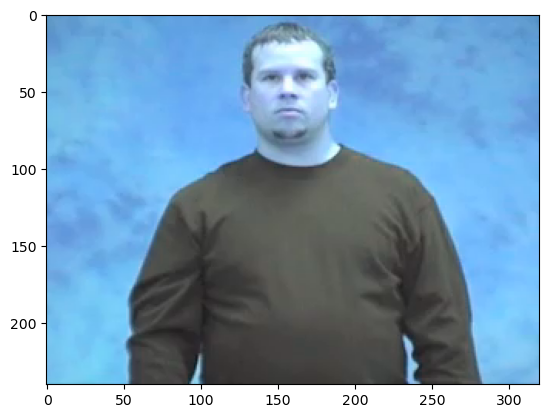

In [3]:
video_dir = '/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/videos/'
video = video_dir + '56811.mp4'


cap = cv2.VideoCapture(video)

while(cap.isOpened()):
    ret, frame = cap.read()
    # cv2.imshow('frame',frame)
    break

plt.figure()
# array = plt.imread(directory + IMAGE_FILES[0])
plt.imshow(frame)
# cap.release()
# cv2.destroyAllWindows()


In [4]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'  # Suppresses TensorFlow logs if used

from absl import logging
logging.set_verbosity(logging.ERROR)

# default Python logging output behavior when present.
if 'absl.logging' in sys.modules:
  import absl.logging
  absl.logging.set_stderrthreshold('fatal')  
import os
os.environ["GLOG_minloglevel"] ="5"
os.environ['OPENCV_LOG_LEVEL'] = 'ERROR'
import mediapipe as mp
debug = False
import numpy as np
import cv2
import os
import sys

class MP():
  def __init__(self):
    # Redirect stdout and stderr to suppress logs
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')
    print("initialize")
    video = '/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/videos/56811.mp4'
    self.get_hands(video)
  
  def __del__(self):
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__

  def mediapipe_to_numpy(self, landmark):
    np_arr = np.zeros(shape=(len(landmark), 3), dtype=float)
    for i, _landmark in enumerate(landmark):
      np_arr[i, 0] = _landmark.x
      np_arr[i, 1] = _landmark.y
      np_arr[i, 2] = _landmark.z
    return np_arr

  def make_annotated_frame(self, mp_drawing, mp_drawing_styles, idx, results, image_width, image_height):
    for hand_landmarks in results.multi_hand_landmarks:
      np_arr = self.mediapipe_to_numpy(hand_landmarks.landmark)
      print('hand_landmarks:', hand_landmarks)
      print(
          f'Index finger tip coordinates: (',
          f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
          f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height})'
      )
      print(type(hand_landmarks))
      print(len(hand_landmarks.landmark))
      print(len(mp_hands.HandLandmark))
      print(dir(hand_landmarks))
      print(np_arr.shape)
      # Create annotated image
      mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
      cv2.imwrite(
          '/tmp/annotated_image' + str(idx) + '.png', cv2.flip(annotated_image, 1))

  def get_hands(self, video, debug=False):
    cap = cv2.VideoCapture(video)

    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_hands = mp.solutions.hands

    
    with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5) as hands:
      idx = 0
      while(cap.isOpened()):
        ret, frame = cap.read()
        
        # Read an image, flip it around y-axis for correct handedness output (see
        # above).
        # frame = cv2.imread(directory + file)
        image = cv2.flip(frame, 1)
        # Convert the BGR image to RGB before processing.
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Print handedness and draw hand landmarks on the image.
        # print('Handedness:', results.multi_handedness)
        if results.multi_hand_landmarks:
          if debug:
            image_height, image_width, _ = image.shape
            annotated_image = image.copy()
            self.make_annotated_frame(mp_drawing, mp_drawing_styles, idx, results, image_width, image_height)

          for hand_world_landmarks in results.multi_hand_world_landmarks:
            print(dir(hand_world_landmarks))
            np_arr = self.mediapipe_to_numpy(hand_world_landmarks.landmark)
            if debug:
              mp_drawing.plot_landmarks(
                hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)
            print(np_arr)
            
          idx += 1
          if idx == 1:
            break

In [5]:
# For static images:
# directory = '/home/tkg5kq/.cache/kagglehub/datasets/ayuraj/asl-dataset/versions/1/asl_dataset/a/'
# import warnings
# import logging

# stderr = sys.stderr
# sys.stderr = open(os.devnull, 'w')

# # Set logging level to ERROR
# logging.basicConfig(level=logging.ERROR)

# # Suppress all warnings
# warnings.filterwarnings("ignore", category=Warning)

# # Suppress specific warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

media_pipe = MP()
video = '/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/videos/56811.mp4'
# 
# sys.stderr.close()
# sys.stderr = stderr


I0000 00:00:1733846343.974940  828401 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733846344.165093  828694 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.14), renderer: NVIDIA A40/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1733846344.196611  828642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733846344.209320  828674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


W0000 00:00:1733846345.344692  828668 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
I0000 00:00:1733846348.042978  828401 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733846348.111034  828778 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.14), renderer: NVIDIA A40/PCIe/SSE2
W0000 00:00:1733846348.126239  828726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733846348.137015  828757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [6]:
media_pipe.get_hands(video)

In [7]:
from datasets.video_attr import Video_dataset
from utils.Augmentation import get_augmentation
from dotmap import DotMap
import yaml
import torch
import torch.backends.cudnn as cudnn


path = '/scratch/tkg5kq/BIKE/configs/wlasl/wlasl_k400_finetune.yaml'
# path = '/scratch/tkg5kq/BIKE/configs/k400/k400_train_video_attr_vitb-32-f8.yaml'
with open(path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = DotMap(config)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    cudnn.benchmark = True

transform_train = get_augmentation(True, config)
transform_val = get_augmentation(False, config)
print(config.data.attributes_train_path)
train_data = Video_dataset(
        config.data.train_root, config.data.train_list,
        config.data.label_list, num_segments=config.data.num_segments,
        modality=config.data.modality,
        image_tmpl=config.data.image_tmpl, random_shift=config.data.random_shift,
        transform=transform_train, dense_sample=config.data.dense,
        select_topk_attributes=config.data.select_topk_attributes,
        attributes_path=None,
        train_video=False,
        train_pose=True)

TypeError: Video_dataset.__init__() got an unexpected keyword argument 'train_pose'

In [ ]:
print(train_data.video_list[0].label)
print(train_data.video_list[0].num_frames)
print(train_data.video_list[0].path)

In [ ]:
item = train_data.__getitem__(0) #, debug=True)

In [ ]:
from mediapipe.framework.formats.landmark_pb2 import LandmarkList, Landmark

def numpy_to_mediapipe(np_arr):
    # Create a LandmarkList object
    landmark_list_list = []
    
    # Iterate through each row in the NumPy array
    for row in np_arr:
        landmark_list = LandmarkList()
        # Create a new Landmark for each set of coordinates
        for coor in row:
            landmark = Landmark()
            landmark.x = coor[0]
            landmark.y = coor[1]
            landmark.z = coor[2]
            # Append the Landmark to the LandmarkList
            landmark_list.landmark.append(landmark)
        landmark_list_list.append(landmark_list)

    return landmark_list_list

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
poses, labels = item
hand_world_landmarks = numpy_to_mediapipe(np.array(poses))
mp_drawing.plot_landmarks(hand_world_landmarks[7], mp_hands.HAND_CONNECTIONS, azimuth=5)

In [ ]:

from torch.utils.data import DataLoader
# train_sampler = torch.utils.data.distributed.DistributedSampler(train_data)                       
train_loader = DataLoader(train_data,
    batch_size=config.data.batch_size, drop_last=False)

In [ ]:


    
for i, (pose, class_id) in enumerate(train_loader):
    print(pose.shape)
    pose = pose.to(device).reshape(-1, pose.shape[-1])
    print(pose.shape)
    print(pose.dtype)
    break

In [1]:
from datasets.video_dataset import PoseDataset

vd = PoseDataset(
    '/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/resized_wlasl_10/', 
    './lists/wlasl/',
    './lists/wlasl/train_rgb_split_1.txt', 
    './lists/wlasl/labels.csv',
    num_segments=16)



/home/tkg5kq/.local/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/sfs/gpfs/tardis/home/tkg5kq/.local/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/tkg5kq/.conda/envs/video/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[('/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/resized_wlasl_10/cousin/13630.mp4', 0), ('/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/resized_wlasl_10/cousin/13631.mp4', 0), ('/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/resized_wlasl_10/cousin/13632.mp4', 0), ('/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/resized_wlasl_10/cousin/13633.mp4', 0), ('/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/resized_wlasl_10/cousin/13634.mp4', 0), ('/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/resized_wlasl_10/cousin/13635.mp4', 0), ('/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/resized_wlasl_10/cousin/13636.mp4', 0), ('/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/resized_wlasl_10/cousin/13640.mp4', 0), ('/home/tkg5kq/.cache/k

100%|██████████| 8/8 [00:01<00:00,  4.78it/s]


[soon/53292.mp4 0 0, soon/53300.mp4 0 0, soon/53305.mp4 0 0, soon/53293.mp4 0 0, soon/53296.mp4 0 0, soon/53304.mp4 0 0, soon/53301.mp4 0 0, soon/53295.mp4 0 0, soon/66534.mp4 0 0, who/63242.mp4 1 1, who/66778.mp4 1 1, who/63225.mp4 1 1, who/66779.mp4 1 1, who/63237.mp4 1 1, who/63230.mp4 1 1, who/63232.mp4 1 1, who/63236.mp4 1 1, who/69534.mp4 1 1, who/63228.mp4 1 1, who/63231.mp4 1 1, who/63226.mp4 1 1, who/63227.mp4 1 1, cousin/13635.mp4 2 2, cousin/13648.mp4 2 2, cousin/13646.mp4 2 2, cousin/13631.mp4 2 2, cousin/13641.mp4 2 2, cousin/13647.mp4 2 2, cousin/13632.mp4 2 2, cousin/13633.mp4 2 2, cousin/13640.mp4 2 2, cousin/13642.mp4 2 2, cousin/13636.mp4 2 2, cousin/13630.mp4 2 2, deaf/14885.mp4 3 3, deaf/14884.mp4 3 3, deaf/14882.mp4 3 3, deaf/14893.mp4 3 3, deaf/14888.mp4 3 3, deaf/65445.mp4 3 3, deaf/14886.mp4 3 3, deaf/14903.mp4 3 3, deaf/14883.mp4 3 3, deaf/14887.mp4 3 3, help/27217.mp4 4 4, help/27215.mp4 4 4, help/27207.mp4 4 4, help/27206.mp4 4 4, help/65889.mp4 4 4, help/272

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_audio_channels', '_audio_samples', '_compute_frame_pts', '_init_from_metadata', '_resample_video_idx', '_video_height', '_video_max_dimension', '_video_min_dimension', '_video_width', 'clips', 'compute_clips', 'compute_clips_for_video', 'cumulative_sizes', 'frame_rate', 'get_clip', 'get_clip_location', 'metadata', 'num_clips', 'num_frames', 'num_videos', 'num_workers', 'output_format', 'resampling_idxs', 'step', 'subset', 'video_fps', 'video_paths', 'video_pts']
112
5568
torch.Size([16, 256, 456, 3])


/home/tkg5kq/.local/lib/python3.11/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


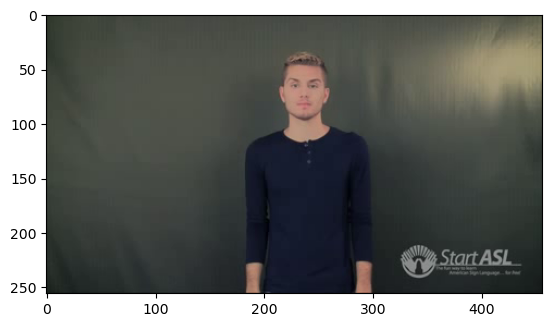

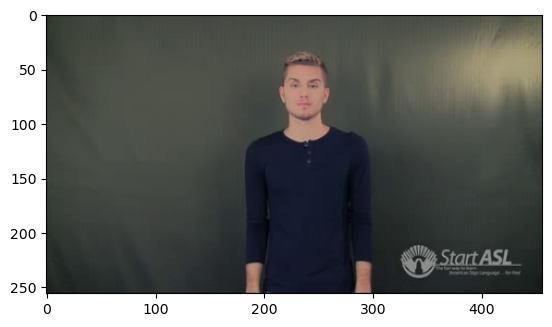

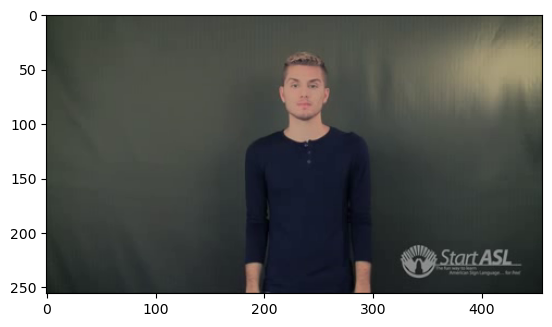

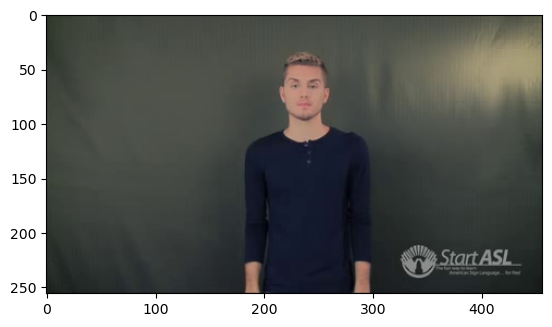

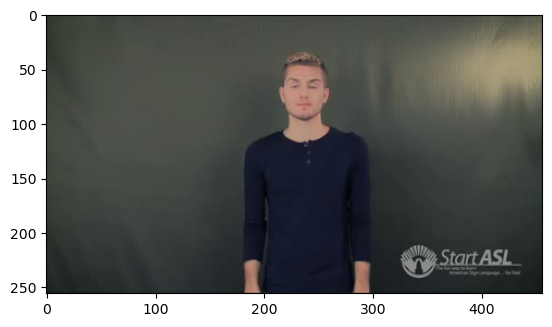

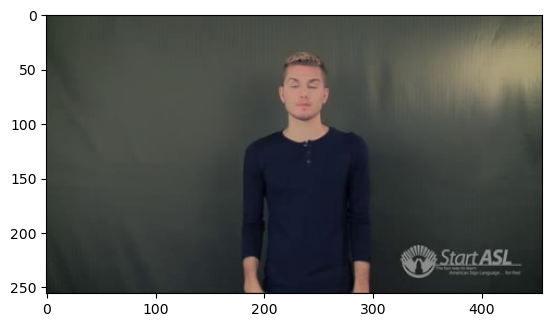

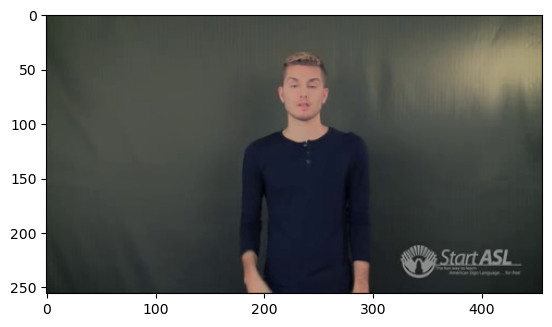

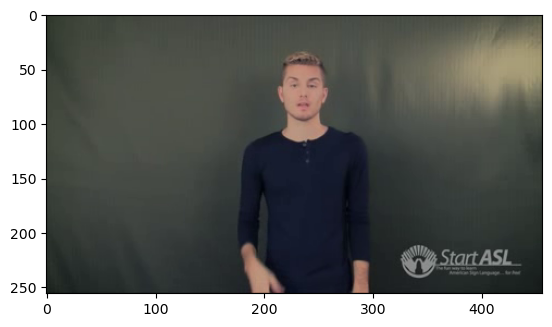

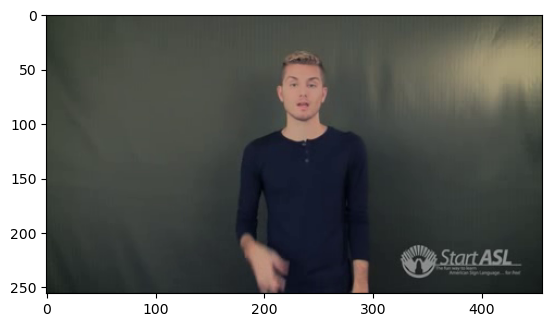

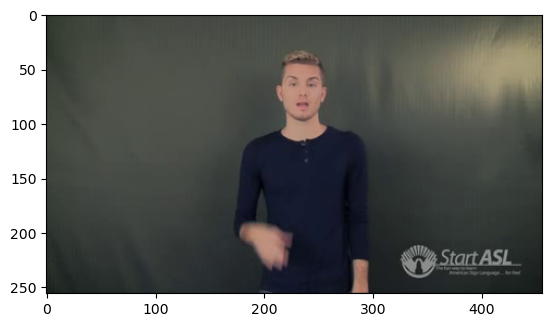

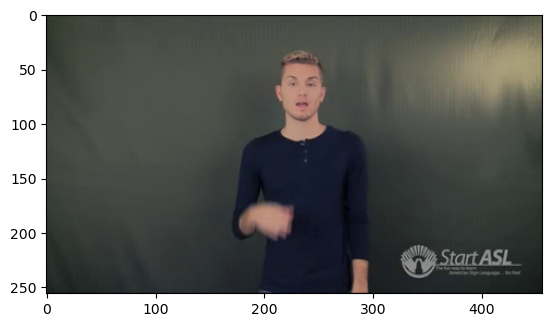

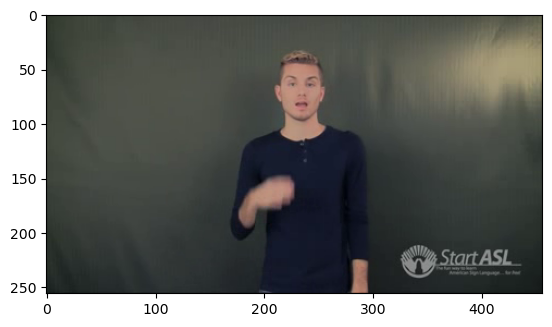

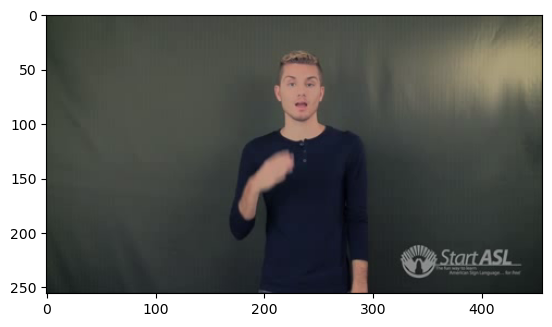

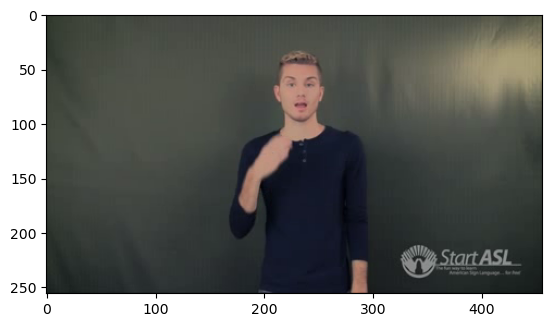

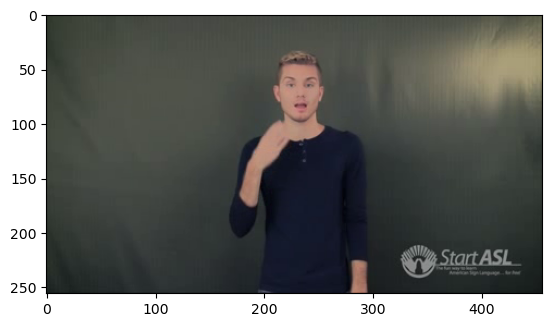

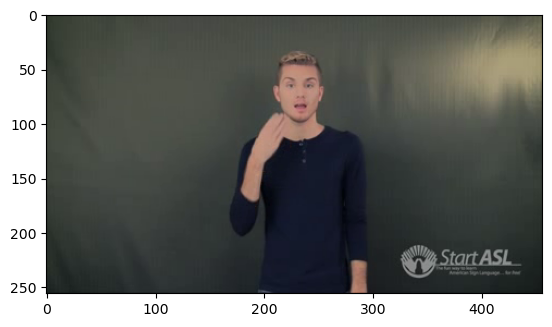

In [4]:

import matplotlib.pyplot as plt

video, audio, info, idx = vd.video_clips.get_clip(91)
print(dir(vd.video_clips))
print(len(vd.video_clips.cumulative_sizes))
print(vd.video_clips.num_clips())
print(video.shape)
for frame in video:
    plt.figure()
    plt.imshow(frame)
    plt.show()